In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def conv_block(x, filters, kernel_size=3, padding='same', activation='leaky_relu', kernel_initializer='he_normal'):
    conv = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
    if activation == 'leaky_relu':
        conv = LeakyReLU()(conv)
    else:
        conv = Activation(activation)(conv)
    conv = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(conv)
    if activation == 'leaky_relu':
        conv = LeakyReLU()(conv)
    else:
        conv = Activation(activation)(conv)
    return conv

def unet_plus_plus(pretrained_weights=None, input_size=(128, 128, 1)):
    size_filter_in = 16
    kernel_init = 'he_normal'
    
    inputs = Input(input_size)
    
    # Đường đi của encoder
    conv1_0 = conv_block(inputs, size_filter_in)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    
    conv2_0 = conv_block(pool1, size_filter_in * 2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    
    conv3_0 = conv_block(pool2, size_filter_in * 4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    
    conv4_0 = conv_block(pool3, size_filter_in * 8)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    
    conv5_0 = conv_block(pool4, size_filter_in * 16)
    
    # Đường đi của decoder (kết nối tầng tầng lớp lớp)
    conv4_1 = conv_block(concatenate([conv4_0, UpSampling2D(size=(2, 2))(conv5_0)], axis=-1), size_filter_in * 8)
    
    conv3_1 = conv_block(concatenate([conv3_0, UpSampling2D(size=(2, 2))(conv4_0)], axis=-1), size_filter_in * 4)
    conv3_2 = conv_block(concatenate([conv3_0, conv3_1, UpSampling2D(size=(2, 2))(conv4_1)], axis=-1), size_filter_in * 4)
    
    conv2_1 = conv_block(concatenate([conv2_0, UpSampling2D(size=(2, 2))(conv3_0)], axis=-1), size_filter_in * 2)
    conv2_2 = conv_block(concatenate([conv2_0, conv2_1, UpSampling2D(size=(2, 2))(conv3_1)], axis=-1), size_filter_in * 2)
    conv2_3 = conv_block(concatenate([conv2_0, conv2_1, conv2_2, UpSampling2D(size=(2, 2))(conv3_2)], axis=-1), size_filter_in * 2)
    
    conv1_1 = conv_block(concatenate([conv1_0, UpSampling2D(size=(2, 2))(conv2_0)], axis=-1), size_filter_in)
    conv1_2 = conv_block(concatenate([conv1_0, conv1_1, UpSampling2D(size=(2, 2))(conv2_1)], axis=-1), size_filter_in)
    conv1_3 = conv_block(concatenate([conv1_0, conv1_1, conv1_2, UpSampling2D(size=(2, 2))(conv2_2)], axis=-1), size_filter_in)
    conv1_4 = conv_block(concatenate([conv1_0, conv1_1, conv1_2, conv1_3, UpSampling2D(size=(2, 2))(conv2_3)], axis=-1), size_filter_in)
    
    conv_final = Conv2D(1, (1, 1), activation='tanh')(conv1_4)
    
    model = Model(inputs, conv_final)
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=tf.keras.losses.Huber(), metrics=['mae'])
    
    if pretrained_weights:
        model.load_weights(pretrained_weights)
    
    return model



In [2]:
root_path = '/kaggle/input/voice-enhancement'

In [3]:
import numpy as np

X_in = np.load(root_path + '/spectrogram/noisy_voice_amp_db.npy')
X_ou = np.load(root_path + '/spectrogram/voice_amp_db.npy')

n_samples = int(X_in.shape[0] * 0.5)

X_in = X_in[n_samples:]
X_ou = X_ou[n_samples:]

X_ou = X_in - X_ou

In [4]:
#to scale between -1 and 1
X_in = (X_in + 46)/50
X_ou = (X_ou -6 )/82

print(X_in.shape)
#Check new distribution
# print(stats.describe(X_in.reshape(-1,1)))
# print(stats.describe(X_ou.reshape(-1,1)))

(20000, 128, 128)


In [5]:
noise_std = 0.05  
noise = np.random.normal(0, noise_std, X_in.shape)
X_in = X_in + noise
X_ou= X_ou + noise 

In [6]:
print(X_in.shape)


(20000, 128, 128)


In [7]:
print(X_in.shape,X_ou.shape)


(20000, 128, 128) (20000, 128, 128)


In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Reshape for training
X_in = X_in[:,:,:]
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
X_ou = X_ou[:,:,:]
X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.2, random_state=42)

#If training from pre-trained weights
#generator_nn = unet_plus_plus(input_size=(128, 128, 1))  
generator_nn=unet_plus_plus(pretrained_weights = '/kaggle/working/model-037-0.007457.keras')

#If training from scratch
#generator_nn=unet()
#Save best models to disk
checkpoint = ModelCheckpoint('/kaggle/working/model-{epoch:03d}-{val_loss:06f}.keras', 
                             verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
generator_nn.summary()
#Training



history = generator_nn.fit(X_train, y_train, epochs=100, batch_size=80, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test))


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ leaky_re_lu[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ leaky_re_lu_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ leaky_re_lu_5[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[

 Total params: 2,289,857 (8.74 MB)

 Trainable params: 2,289,857 (8.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1730537201.725736     126 service.cc:145] XLA service 0x78df1c0ac9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730537201.726408     126 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730537230.109052     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0073 - mae: 0.0873
Epoch 1: val_loss improved from inf to 0.00714, saving model to /kaggle/working/model-001-0.007145.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 227ms/step - loss: 0.0073 - mae: 0.0873 - val_loss: 0.0071 - val_mae: 0.0854
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0069 - mae: 0.0853
Epoch 2: val_loss did not improve from 0.00714
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step - loss: 0.0069 - mae: 0.0853 - val_loss: 0.0072 - val_mae: 0.0864
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0067 - mae: 0.0842
Epoch 3: val_loss improved from 0.00714 to 0.00693, saving model to /kaggle/working/model-003-0.006927.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 0.0067 - mae: 0.0842 - val_loss: 0.0069 - val_mae: 0.0860
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0066 - mae: 0.0838
Epoch 4: val_loss improved from 0.00693 to 0.00689, saving model to /kaggle/working/m

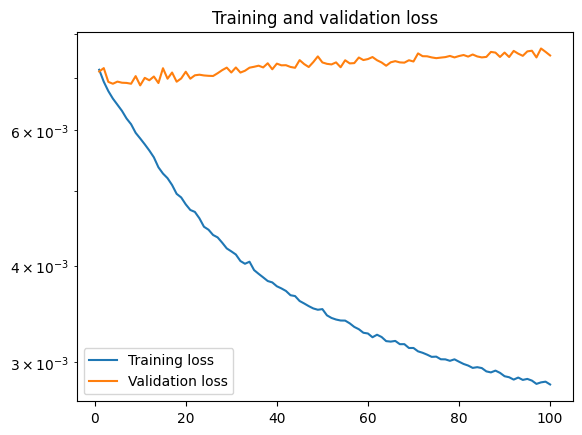

In [9]:
#Plot training and validation loss
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.yscale('log')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
#Predict and QC the output
X_pred_test = generator_nn.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


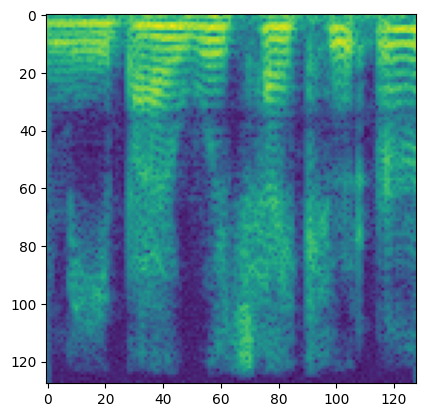

In [14]:

import matplotlib.pyplot as plt
%matplotlib inline
id = 350
plt.imshow(X_test[id,:,:,0])

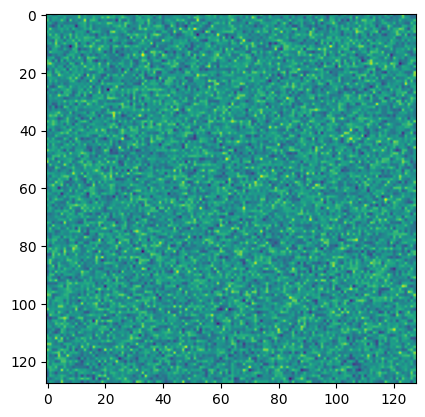

In [15]:
plt.imshow(y_test[id,:,:,0])


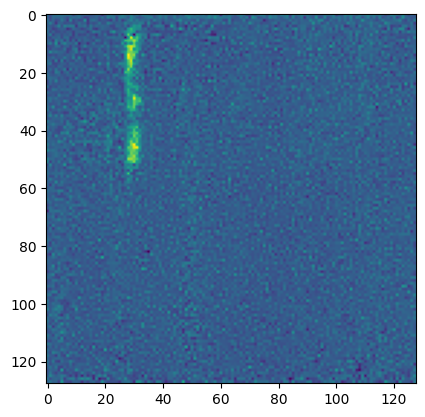

In [16]:
plt.imshow(X_pred_test[id,:,:,0])


In [17]:
generator_nn.save("/kaggle/working/unetplusplus-100%-data.keras")


In [27]:
X_in = np.load(root_path + '/spectrogram/noisy_voice_amp_db.npy')
X_ou = np.load(root_path + '/spectrogram/voice_amp_db.npy')

# Lấy kích thước 70% dữ liệu
n_samples = int(X_in.shape[0] * 0.8)

# Chỉ lấy 70% dữ liệu theo chiều đầu tiên
X_in = X_in[n_samples:]
X_ou = X_ou[n_samples:]

# Thực hiện phép trừ
X_ou = X_in - X_ou

In [28]:
X_in = (X_in + 46)/50
X_ou = (X_ou -6 )/82

print(X_in.shape)

(8000, 128, 128)


In [29]:
X_in = X_in[:,:,:]
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
X_ou = X_ou[:,:,:]
X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.2, random_state=42)

#If training from pre-trained weights
#generator_nn = unet_plus_plus(input_size=(128, 128, 1))  
generator_nn=unet_plus_plus(pretrained_weights = '/kaggle/working/model-040-0.005780.keras')

#If training from scratch
#generator_nn=unet()
#Save best models to disk
checkpoint = ModelCheckpoint('/kaggle/working/model-{epoch:03d}-{val_loss:06f}.keras', 
                             verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
generator_nn.summary()
#Training



history = generator_nn.fit(X_train, y_train, epochs=50, batch_size=80, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test))

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      2,320 │ leaky_re_lu_18[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ leaky_re_lu_19[0… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ leaky_re_lu_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ leaky_re_lu_21[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_22      │ (None, 32, 32,    │          0 │ conv2d_23[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ leaky_re_lu_22[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_23      │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ leaky_re_lu_23[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_6[

 Total params: 1,962,337 (7.49 MB)

 Trainable params: 1,962,337 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0066 - mae: 0.0774
Epoch 1: val_loss improved from inf to 0.00612, saving model to /kaggle/working/model-001-0.006117.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - loss: 0.0066 - mae: 0.0774 - val_loss: 0.0061 - val_mae: 0.0761
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0053 - mae: 0.0692
Epoch 2: val_loss improved from 0.00612 to 0.00585, saving model to /kaggle/working/model-002-0.005853.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0053 - mae: 0.0692 - val_loss: 0.0059 - val_mae: 0.0706
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0047 - mae: 0.0651
Epoch 3: val_loss did not improve from 0.00585
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0047 - mae: 0.0651 - val_loss: 0.0059 - val_mae: 0.0723
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0042 - mae: 0.0610
Epoch 4: val_loss did not improve from 0.00585
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.00

In [30]:
generator_nn.save("/kaggle/working/unetplus-80%+20%-data.keras")


In [31]:
X_pred_test = generator_nn.predict(X_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


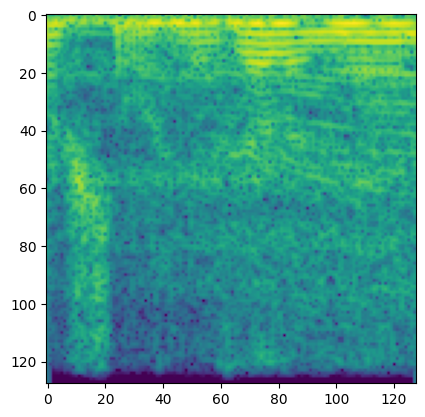

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
id = 250
plt.imshow(X_test[id,:,:,0])

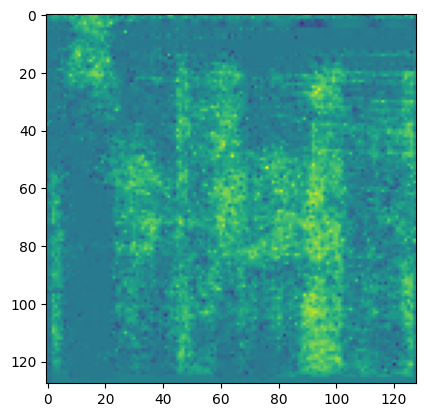

In [37]:
plt.imshow(y_test[id,:,:,0])


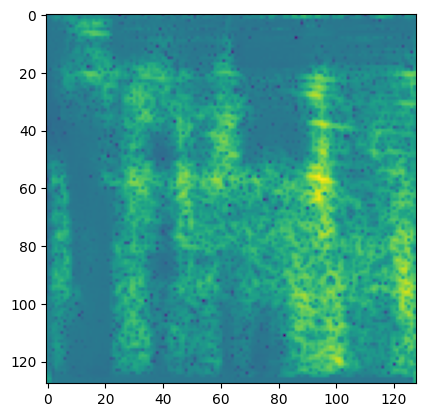

In [38]:
plt.imshow(X_pred_test[id,:,:,0])
